X shape: (22950, 147) | y shape: (22950, 15) | stations: 15
k=1  train_acc=1.000  test_acc=0.426
k=2  train_acc=0.565  test_acc=0.445
k=3  train_acc=0.571  test_acc=0.458
k=4  train_acc=0.523  test_acc=0.462

Best k by test accuracy: 4


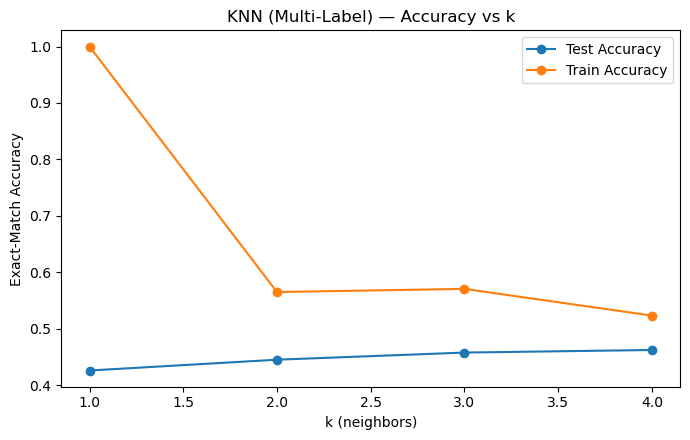

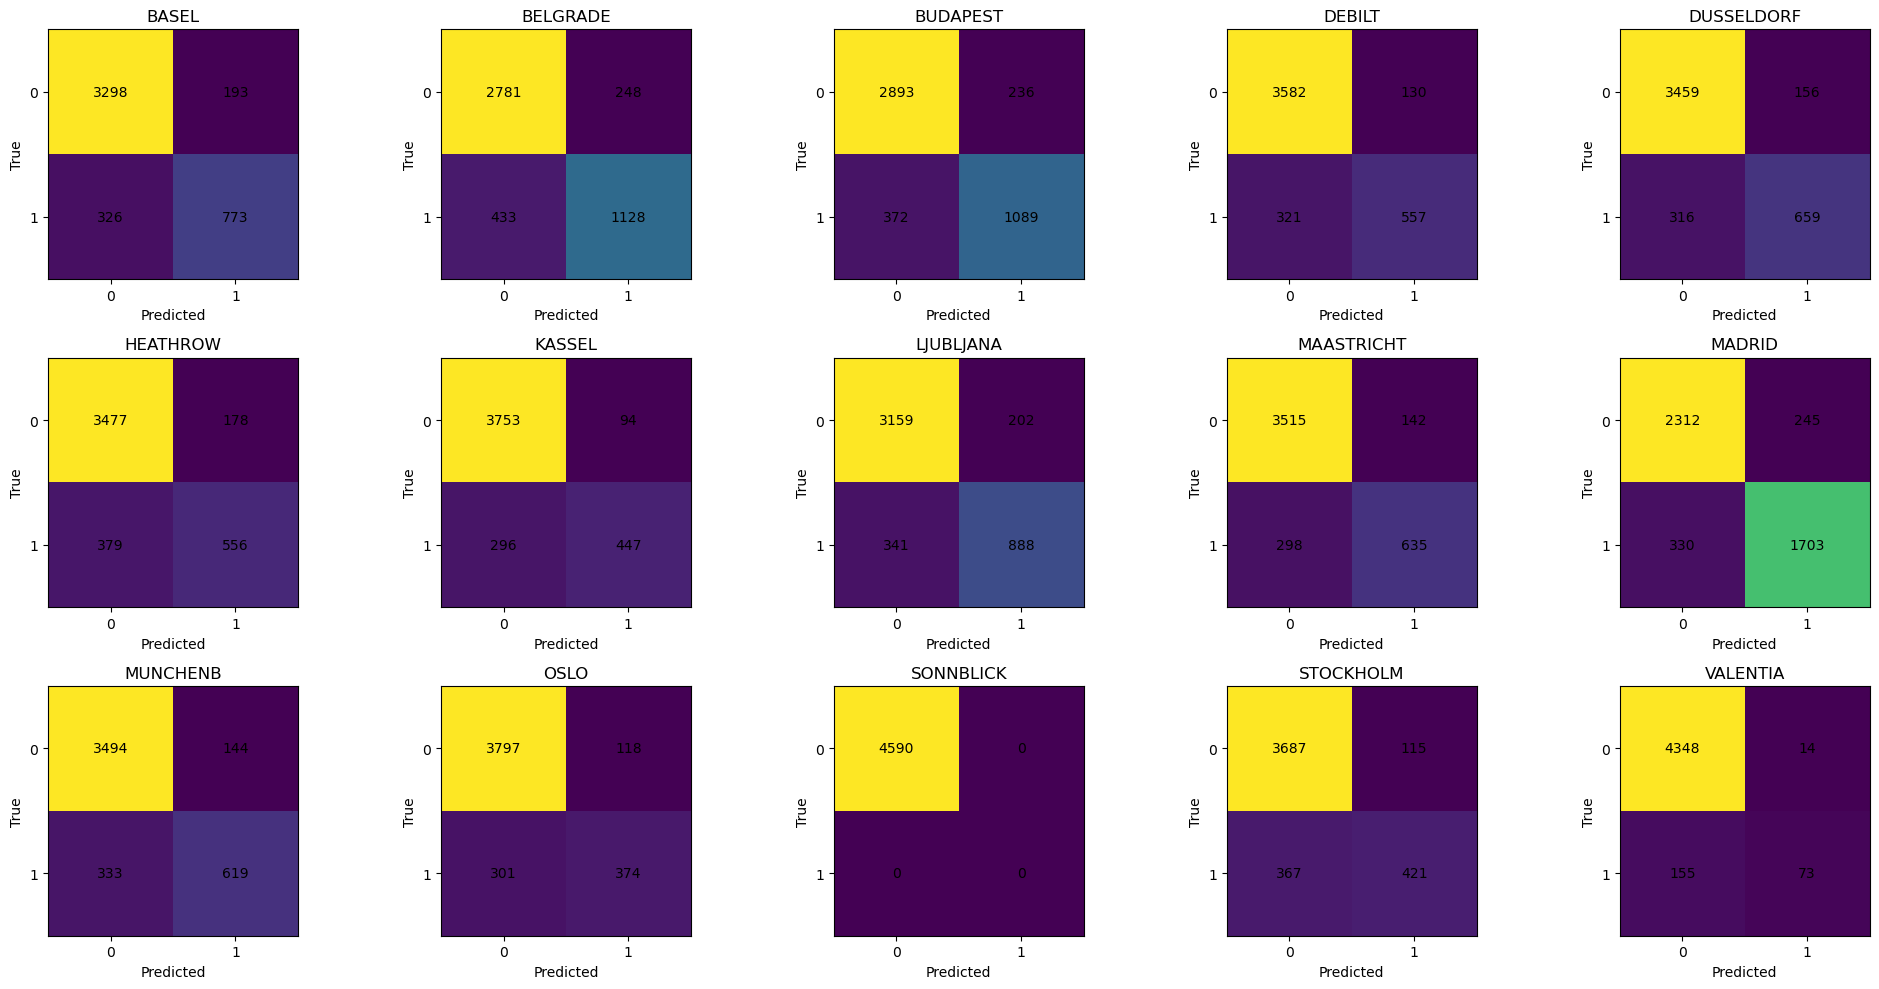


Saved: accuracy_vs_k.png, confusion_matrices.png, metrics_summary.txt


In [1]:
# Exercise 1.4 — KNN with Multi-Label Answers (Pleasant Weather)
# Rhys Ingalls — CareerFoundry: Machine Learning with Python
#
# What this cell does
# -------------------
# 1) Loads the scaled weather dataset (X) and the pleasant-weather answers (y)
# 2) Aligns the columns by station (keeps only stations that exist in the answer key)
# 3) Drops DATE/MONTH from X and DATE from y
# 4) Trains KNN inside a MultiOutputClassifier
# 5) Sweeps k = 1..4, records train/test exact-match accuracy, and plots accuracy vs k
# 6) Trains a final model at the best k and plots 15 confusion matrices (one per station)
# 7) Saves: accuracy_vs_k.png, confusion_matrices.png, metrics_summary.txt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# ----------------- Configuration -----------------
X_FILE = "Dataset-weather-prediction-dataset-processed_scaled.csv"
Y_FILE = "Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2
K_VALUES = [1, 2, 3, 4]        # per assignment (reduced from 60)

# Optional: speed up local testing (set to integers or leave as None)
TRAIN_SAMPLE = None            # e.g., 2000
TEST_SAMPLE  = None            # e.g., 3000

# ----------------- Load the data -----------------
X_df = pd.read_csv(X_FILE)
y_df = pd.read_csv(Y_FILE)

# Build the list of station names from y (columns like STATION_pleasant_weather)
assert "DATE" in y_df.columns, "Expected DATE column in answers CSV."
y_station_cols = [c for c in y_df.columns if c != "DATE"]
y_stations = [c.replace("_pleasant_weather", "") for c in y_station_cols]

# Helper to extract station prefix from X's columns (e.g., 'BASEL_cloud_cover' -> 'BASEL')
def station_prefix(col):
    if col in ["DATE", "MONTH"]:
        return col
    parts = col.split("_", 1)
    return parts[0] if len(parts) > 1 else col

# Keep only X columns whose station exists in the y answers
cols_to_keep = ["DATE", "MONTH"]
for c in X_df.columns:
    if c in ["DATE", "MONTH"]:
        continue
    if station_prefix(c) in y_stations:
        cols_to_keep.append(c)

X_aligned = X_df[cols_to_keep].copy()

# Drop DATE/MONTH from X, and DATE from y (per assignment)
X = X_aligned.drop(columns=["DATE", "MONTH"]).copy()
y = y_df.drop(columns=["DATE"]).copy()

print(f"X shape: {X.shape} | y shape: {y.shape} | stations: {len(y_stations)}")

# ---------------- Train/Test split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

# Optional downsampling for faster iteration (use full data for final run)
if TRAIN_SAMPLE is not None and TRAIN_SAMPLE < len(X_train):
    rng = np.random.default_rng(RANDOM_STATE)
    idx = rng.choice(X_train.index.values, size=TRAIN_SAMPLE, replace=False)
    X_train, y_train = X_train.loc[idx], y_train.loc[idx]

if TEST_SAMPLE is not None and TEST_SAMPLE < len(X_test):
    rng = np.random.default_rng(RANDOM_STATE + 1)
    idx = rng.choice(X_test.index.values, size=TEST_SAMPLE, replace=False)
    X_test, y_test = X_test.loc[idx], y_test.loc[idx]

# ------------- Sweep k and collect accuracy -------------
train_acc, test_acc = [], []

for k in K_VALUES:
    clf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=k), n_jobs=-1)
    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test  = clf.predict(X_test)

    # Exact-match accuracy across all 15 labels
    tr = accuracy_score(y_train, y_pred_train)
    te = accuracy_score(y_test,  y_pred_test)

    train_acc.append(tr)
    test_acc.append(te)
    print(f"k={k}  train_acc={tr:.3f}  test_acc={te:.3f}")

# Choose best k by highest test accuracy (tie -> smallest k)
best_k = K_VALUES[int(np.argmax(test_acc))]
print(f"\nBest k by test accuracy: {best_k}")

# ---------------- Plot accuracy vs k ----------------
plt.figure(figsize=(7, 4.5))
plt.plot(K_VALUES, test_acc, marker='o', label='Test Accuracy')
plt.plot(K_VALUES, train_acc, marker='o', label='Train Accuracy')
plt.xlabel("k (neighbors)")
plt.ylabel("Exact-Match Accuracy")
plt.title("KNN (Multi-Label) — Accuracy vs k")
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_vs_k.png", dpi=150, bbox_inches="tight")
plt.show()

# ------------- Final model and confusion matrices -------------
final_clf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=best_k), n_jobs=-1)
final_clf.fit(X_train, y_train)
y_pred = final_clf.predict(X_test)

stations_in_order = [c.replace("_pleasant_weather", "") for c in y.columns]

rows, cols = 3, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.ravel()

for j, st in enumerate(stations_in_order):
    cm = confusion_matrix(y_test.iloc[:, j], y_pred[:, j], labels=[0, 1])
    ax = axes[j]
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(st)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    # cell annotations
    for (r, c), val in np.ndenumerate(cm):
        ax.text(c, r, int(val), ha='center', va='center', color='black')

# Hide any extra axes if fewer than 15
for h in range(len(stations_in_order), rows * cols):
    axes[h].axis('off')

plt.tight_layout()
plt.savefig("confusion_matrices.png", dpi=150, bbox_inches="tight")
plt.show()

# ---------------- Save a short metrics summary ----------------
with open("metrics_summary.txt", "w", encoding="utf-8") as f:
    f.write("KNN Multi-Label Pleasant-Weather Prediction\n")
    f.write("==========================================\n\n")
    f.write(f"Train size: {len(X_train):,} | Test size: {len(X_test):,}\n")
    f.write(f"k tested: {K_VALUES}\n")
    f.write("Train accuracy per k: " + ", ".join(f"{a:.4f}" for a in train_acc) + "\n")
    f.write("Test  accuracy per k: " + ", ".join(f"{a:.4f}" for a in test_acc) + "\n")
    f.write(f"\nBest k by test accuracy: {best_k}\n")
    final_train_acc = accuracy_score(y_train, final_clf.predict(X_train))
    final_test_acc  = accuracy_score(y_test,  y_pred)
    f.write(f"Final train exact-match accuracy: {final_train_acc:.4f}\n")
    f.write(f"Final test  exact-match accuracy: {final_test_acc:.4f}\n")

print("\nSaved: accuracy_vs_k.png, confusion_matrices.png, metrics_summary.txt")


In [7]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Use the exact station order of y's columns to stay aligned with y_pred
stations = [c.replace("_pleasant_weather", "") for c in y.columns]

rows = []
for j, name in enumerate(stations):
    y_true = y_test.iloc[:, j].to_numpy()
    y_hat  = y_pred[:, j]

    # Force a 2x2 matrix even if a class is missing (e.g., all zeros)
    cm = confusion_matrix(y_true, y_hat, labels=[0, 1])

    # cm is now guaranteed 2x2: [[tn, fp],[fn, tp]]
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()
    acc = (tn + tp) / total if total else 0.0

    rows.append({
        "Weather Station": name,
        "Accurate predictions": int(tn + tp),
        "False positive": int(fp),
        "False negative": int(fn),
        "Accuracy rate": f"{acc*100:.1f}%"
    })

df_summary = pd.DataFrame(rows)

# Average accuracy (numeric mean of the per-station % values)
avg_acc = df_summary["Accuracy rate"].str.rstrip('%').astype(float).mean()
df_summary.loc[len(df_summary)] = {
    "Weather Station": "Average",
    "Accurate predictions": "",
    "False positive": "",
    "False negative": "",
    "Accuracy rate": f"{avg_acc:.1f}%"
}

display(df_summary)

# Optional: save to CSV
df_summary.to_csv("station_accuracy_summary.csv", index=False)
print("Saved: station_accuracy_summary.csv")


,Weather Station,Accurate predictions,False positive,False negative,Accuracy rate
0,BASEL,4071,193,326,88.7%
1,BELGRADE,3909,248,433,85.2%
2,BUDAPEST,3982,236,372,86.8%
3,DEBILT,4139,130,321,90.2%
4,DUSSELDORF,4118,156,316,89.7%
5,HEATHROW,4033,178,379,87.9%
6,KASSEL,4200,94,296,91.5%
7,LJUBLJANA,4047,202,341,88.2%
8,MAASTRICHT,4150,142,298,90.4%
9,MADRID,4015,245,330,87.5%


Saved: station_accuracy_summary.csv
